In [9]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import cv2
from PIL import Image
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Setup paths
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
src_path = project_root / 'src'
sys.path.append(str(src_path))

# Import custom modules
from models.unet import create_model
from datasets.fire_dataset import FireDataModule
from losses.dice_focal import create_loss_function
from train.metrics import FireDetectionMetrics

print("Environment setup complete!")
print(f"Project root: {project_root}")
print(f"GPU available: {torch.cuda.is_available()}")

Environment setup complete!
Project root: e:\Forest_V7\Forest-Fire-Classification_and_Spread-Prediction
GPU available: True


In [10]:
with open(project_root / 'configs/model.yaml', 'r') as f:
    model_config = yaml.safe_load(f)

with open(project_root / 'configs/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)

print("Configurations loaded successfully")

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(model_config['model'])
model = model.to(device)

# Load best checkpoint
checkpoint_path = project_root / 'checkpoints' / 'best_checkpoint.pth'
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
else:
    print("Warning: Best checkpoint not found, using initialized model")

model.eval()

Configurations loaded successfully
Loaded best checkpoint from epoch 40


UNet(
  (encoder): PretrainedEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
import os
import numpy as np
from PIL import Image

# --- Data module config ---
data_module_config = {
    'data_root': 'data/interim/tiles',
    'batch_size': 8,
    'image_size': data_config['data'].get('tile_size', 512),
    'val_split': data_config['data'].get('val_ratio', 0.2),
    'test_split': data_config['data'].get('test_ratio', 0.1),
    'num_workers': 2,
    'use_weighted_sampling': False,
    'task': 'segmentation',
    'augmentation': {'enabled': False}
}

# --- Ensure dataset exists ---
images_dir = os.path.join(data_module_config['data_root'], "images")
masks_dir = os.path.join(data_module_config['data_root'], "masks")

os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)


# --- Create data module ---
data_module = FireDataModule(
    tiles_dir=data_module_config['data_root'],
    batch_size=data_module_config['batch_size'],
    num_workers=data_module_config['num_workers'],
    val_split=data_module_config['val_split'],
    test_split=data_module_config['test_split'],
    image_size=data_module_config['image_size'],
    use_weighted_sampling=data_module_config['use_weighted_sampling'],
    task=data_module_config['task'],
    augmentation_config=data_module_config['augmentation']
)

# --- Get data loaders ---
test_loader = data_module.test_dataloader()
val_loader = data_module.val_dataloader()

print(f"Test batches: {len(test_loader)}")
print(f"Validation batches: {len(val_loader)}")


Fire distribution - Train: 867/5103 (17.0%), Val: 248/1458 (17.0%)


Image not found: data\interim\tiles\images\BritishColumbia-2023-06-29_r003_c008.png
Image not found: data\interim\tiles\images\Quebec-2023-06-22_r005_c000.png
Image not found: data\interim\tiles\images\Alberta-2023-06-29_r003_c000.png
Image not found: data\interim\tiles\images\Ontario-2023-06-27_r005_c002.png
Image not found: data\interim\tiles\images\Quebec-2023-06-02_r003_c007.png
Image not found: data\interim\tiles\images\Alberta-2023-06-15_r006_c002.png
Image not found: data\interim\tiles\images\Quebec-2023-06-19_r006_c004.png
Image not found: data\interim\tiles\images\Quebec-2023-06-26_r009_c002.png
Image not found: data\interim\tiles\images\Quebec-2023-06-30_r008_c000.png
Image not found: data\interim\tiles\images\Alberta-2023-06-21_r002_c001.png
Image not found: data\interim\tiles\images\BritishColumbia-2023-06-05_r005_c002.png
Image not found: data\interim\tiles\images\BritishColumbia-2023-06-18_r005_c000.png
Image not found: data\interim\tiles\images\Ontario-2023-06-11_r007_c0

Test batches: 16
Validation batches: 31


In [12]:
# ## 3. Model Evaluation Functions

def denormalize_image(tensor):
    """Convert normalized tensor back to displayable image."""
    # Reverse ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    if tensor.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    
    img = tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def predict_batch(model, batch, threshold=0.5):
    """Generate predictions for a batch."""
    images, masks = batch
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, dict):
            logits = outputs['out']
        else:
            logits = outputs
        
        # Convert to probabilities
        probs = torch.sigmoid(logits)
        
        # Apply threshold
        preds = (probs > threshold).float()
    
    return {
        'images': images.cpu(),
        'masks': masks.cpu(),
        'logits': logits.cpu(),
        'probs': probs.cpu(),
        'predictions': preds.cpu()
    }

def compute_metrics_on_loader(model, data_loader, threshold=0.5):
    """Compute comprehensive metrics on a data loader."""
    metrics = FireDetectionMetrics(threshold=threshold, device=device)
    
    all_probs = []
    all_targets = []
    
    for batch in data_loader:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        with torch.no_grad():
            outputs = model(images)
            if isinstance(outputs, dict):
                logits = outputs['out']
            else:
                logits = outputs
        
        # Update metrics
        metrics.update(logits, masks)
        
        # Collect for ROC/PR curves
        probs = torch.sigmoid(logits).cpu().flatten()
        targets = masks.cpu().flatten()
        
        # Sample to avoid memory issues
        sample_size = min(1000, len(probs))
        indices = torch.randperm(len(probs))[:sample_size]
        
        all_probs.extend(probs[indices].numpy())
        all_targets.extend(targets[indices].numpy())
    
    final_metrics = metrics.compute_all_metrics()
    
    return final_metrics, np.array(all_probs), np.array(all_targets)

In [13]:
# ## 4. Comprehensive Model Evaluation

print("Evaluating model on test set...")
test_metrics, test_probs, test_targets = compute_metrics_on_loader(model, test_loader)

print("Evaluating model on validation set...")
val_metrics, val_probs, val_targets = compute_metrics_on_loader(model, val_loader)

# Display results
print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

print(f"\nTest Set Performance:")
print(f"  Fire F1 Score: {test_metrics.get('fire_f1', 0):.4f}")
print(f"  Mean IoU: {test_metrics.get('mean_iou', 0):.4f}")
print(f"  Fire Precision: {test_metrics.get('fire_precision', 0):.4f}")
print(f"  Fire Recall: {test_metrics.get('fire_detection_rate', 0):.4f}")
print(f"  Pixel Accuracy: {test_metrics.get('pixel_accuracy', 0):.4f}")
print(f"  ROC AUC: {test_metrics.get('roc_auc', 0):.4f}")

print(f"\nValidation Set Performance:")
print(f"  Fire F1 Score: {val_metrics.get('fire_f1', 0):.4f}")
print(f"  Mean IoU: {val_metrics.get('mean_iou', 0):.4f}")
print(f"  Fire Precision: {val_metrics.get('fire_precision', 0):.4f}")
print(f"  Fire Recall: {val_metrics.get('fire_detection_rate', 0):.4f}")
print(f"  Pixel Accuracy: {val_metrics.get('pixel_accuracy', 0):.4f}")
print(f"  ROC AUC: {val_metrics.get('roc_auc', 0):.4f}")

Evaluating model on test set...
Evaluating model on validation set...

MODEL EVALUATION RESULTS

Test Set Performance:
  Fire F1 Score: 0.8672
  Mean IoU: 0.7656
  Fire Precision: 0.8428
  Fire Recall: 0.8931
  Pixel Accuracy: 0.9994
  ROC AUC: 0.9998

Validation Set Performance:
  Fire F1 Score: 0.8744
  Mean IoU: 0.7769
  Fire Precision: 0.8508
  Fire Recall: 0.8994
  Pixel Accuracy: 0.9993
  ROC AUC: 0.9999


In [14]:
# ## 5. Visualization Functions

def plot_roc_pr_curves(probs, targets, title_prefix=""):
    """Plot ROC and Precision-Recall curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{title_prefix}ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(targets, probs)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{title_prefix}Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, data_loader, num_samples=8, threshold=0.5):
    """Visualize model predictions vs ground truth."""
    # Get a batch of samples
    batch = next(iter(data_loader))
    results = predict_batch(model, batch, threshold)
    
    images = results['images']
    masks = results['masks']
    probs = results['probs']
    preds = results['predictions']
    
    num_samples = min(num_samples, len(images))
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Original image
        img = denormalize_image(images[i])
        axes[i, 0].imshow(img.permute(1, 2, 0))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        gt_mask = masks[i].squeeze() if masks[i].dim() > 2 else masks[i]
        axes[i, 1].imshow(gt_mask, cmap='Reds', alpha=0.8)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction probability
        prob_map = probs[i].squeeze() if probs[i].dim() > 2 else probs[i]
        axes[i, 2].imshow(prob_map, cmap='hot', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Probability Map (max: {prob_map.max():.3f})')
        axes[i, 2].axis('off')
        
        # Binary prediction
        pred_mask = preds[i].squeeze() if preds[i].dim() > 2 else preds[i]
        axes[i, 3].imshow(pred_mask, cmap='Reds', alpha=0.8)
        axes[i, 3].set_title(f'Prediction (t={threshold})')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_threshold_analysis(model, data_loader, thresholds=np.arange(0.1, 0.9, 0.1)):
    """Analyze performance across different thresholds."""
    results = []
    
    print("Analyzing thresholds...")
    for threshold in thresholds:
        metrics, _, _ = compute_metrics_on_loader(model, data_loader, threshold)
        results.append({
            'threshold': threshold,
            'f1': metrics.get('fire_f1', 0),
            'precision': metrics.get('fire_precision', 0),
            'recall': metrics.get('fire_detection_rate', 0),
            'iou': metrics.get('mean_iou', 0)
        })
        print(f"  Threshold {threshold:.1f}: F1={metrics.get('fire_f1', 0):.3f}")
    
    df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 8))
    plt.plot(df['threshold'], df['f1'], 'o-', label='F1 Score', linewidth=2)
    plt.plot(df['threshold'], df['precision'], 's-', label='Precision', linewidth=2)
    plt.plot(df['threshold'], df['recall'], '^-', label='Recall', linewidth=2)
    plt.plot(df['threshold'], df['iou'], 'd-', label='IoU', linewidth=2)
    
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Mark optimal F1 threshold
    best_idx = df['f1'].idxmax()
    best_threshold = df.iloc[best_idx]['threshold']
    best_f1 = df.iloc[best_idx]['f1']
    plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
    plt.text(best_threshold + 0.02, best_f1, f'Best: {best_threshold:.1f}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.show()
    
    return df

def create_overlay_visualization(model, data_loader, num_samples=4):
    """Create overlay visualizations of predictions on original images."""
    batch = next(iter(data_loader))
    results = predict_batch(model, batch, threshold=0.5)
    
    images = results['images']
    masks = results['masks']
    probs = results['probs']
    
    num_samples = min(num_samples, len(images))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_samples):
        # Original with ground truth overlay
        img = denormalize_image(images[i]).permute(1, 2, 0).numpy()
        gt_mask = masks[i].squeeze().numpy() if masks[i].dim() > 2 else masks[i].numpy()
        
        axes[0, i].imshow(img)
        axes[0, i].imshow(gt_mask, cmap='Reds', alpha=0.5)
        axes[0, i].set_title('Ground Truth Overlay')
        axes[0, i].axis('off')
        
        # Original with prediction overlay
        prob_map = probs[i].squeeze().numpy() if probs[i].dim() > 2 else probs[i].numpy()
        
        axes[1, i].imshow(img)
        axes[1, i].imshow(prob_map, cmap='hot', alpha=0.6, vmin=0, vmax=1)
        axes[1, i].set_title('Prediction Overlay')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


GENERATING VISUALIZATIONS

1. ROC and Precision-Recall Curves


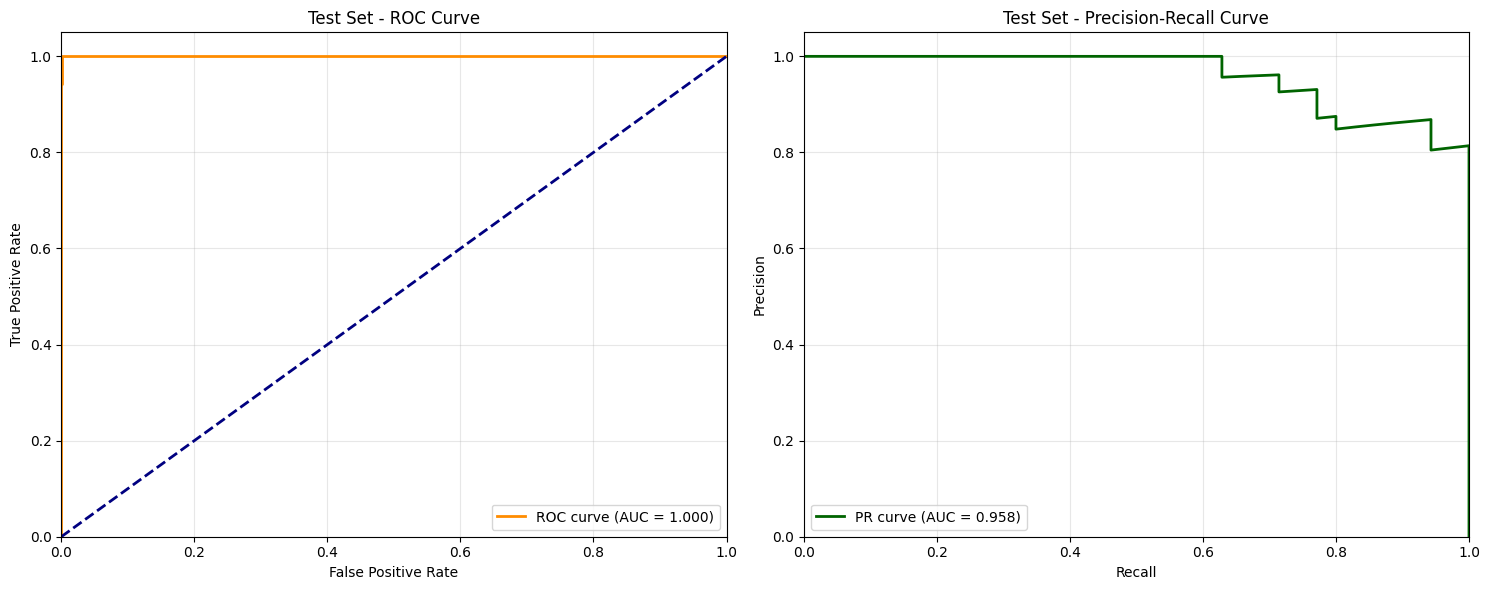

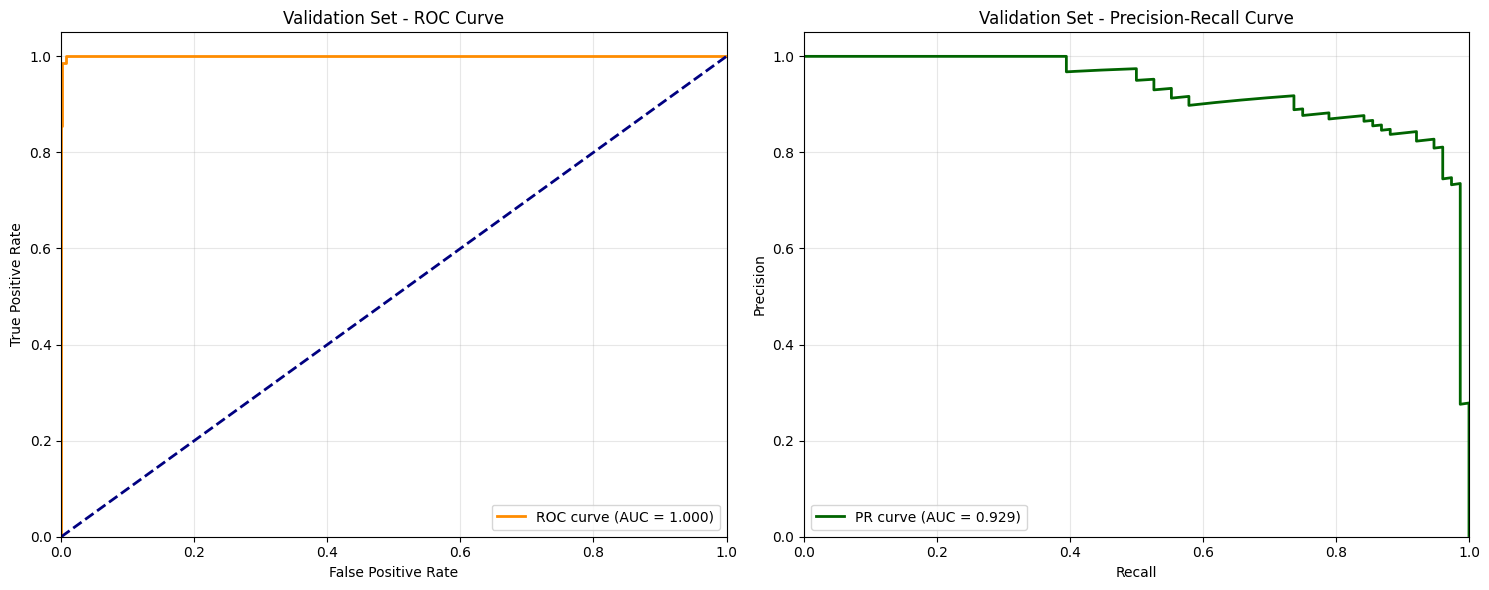


2. Prediction Visualizations
Test Set Predictions:


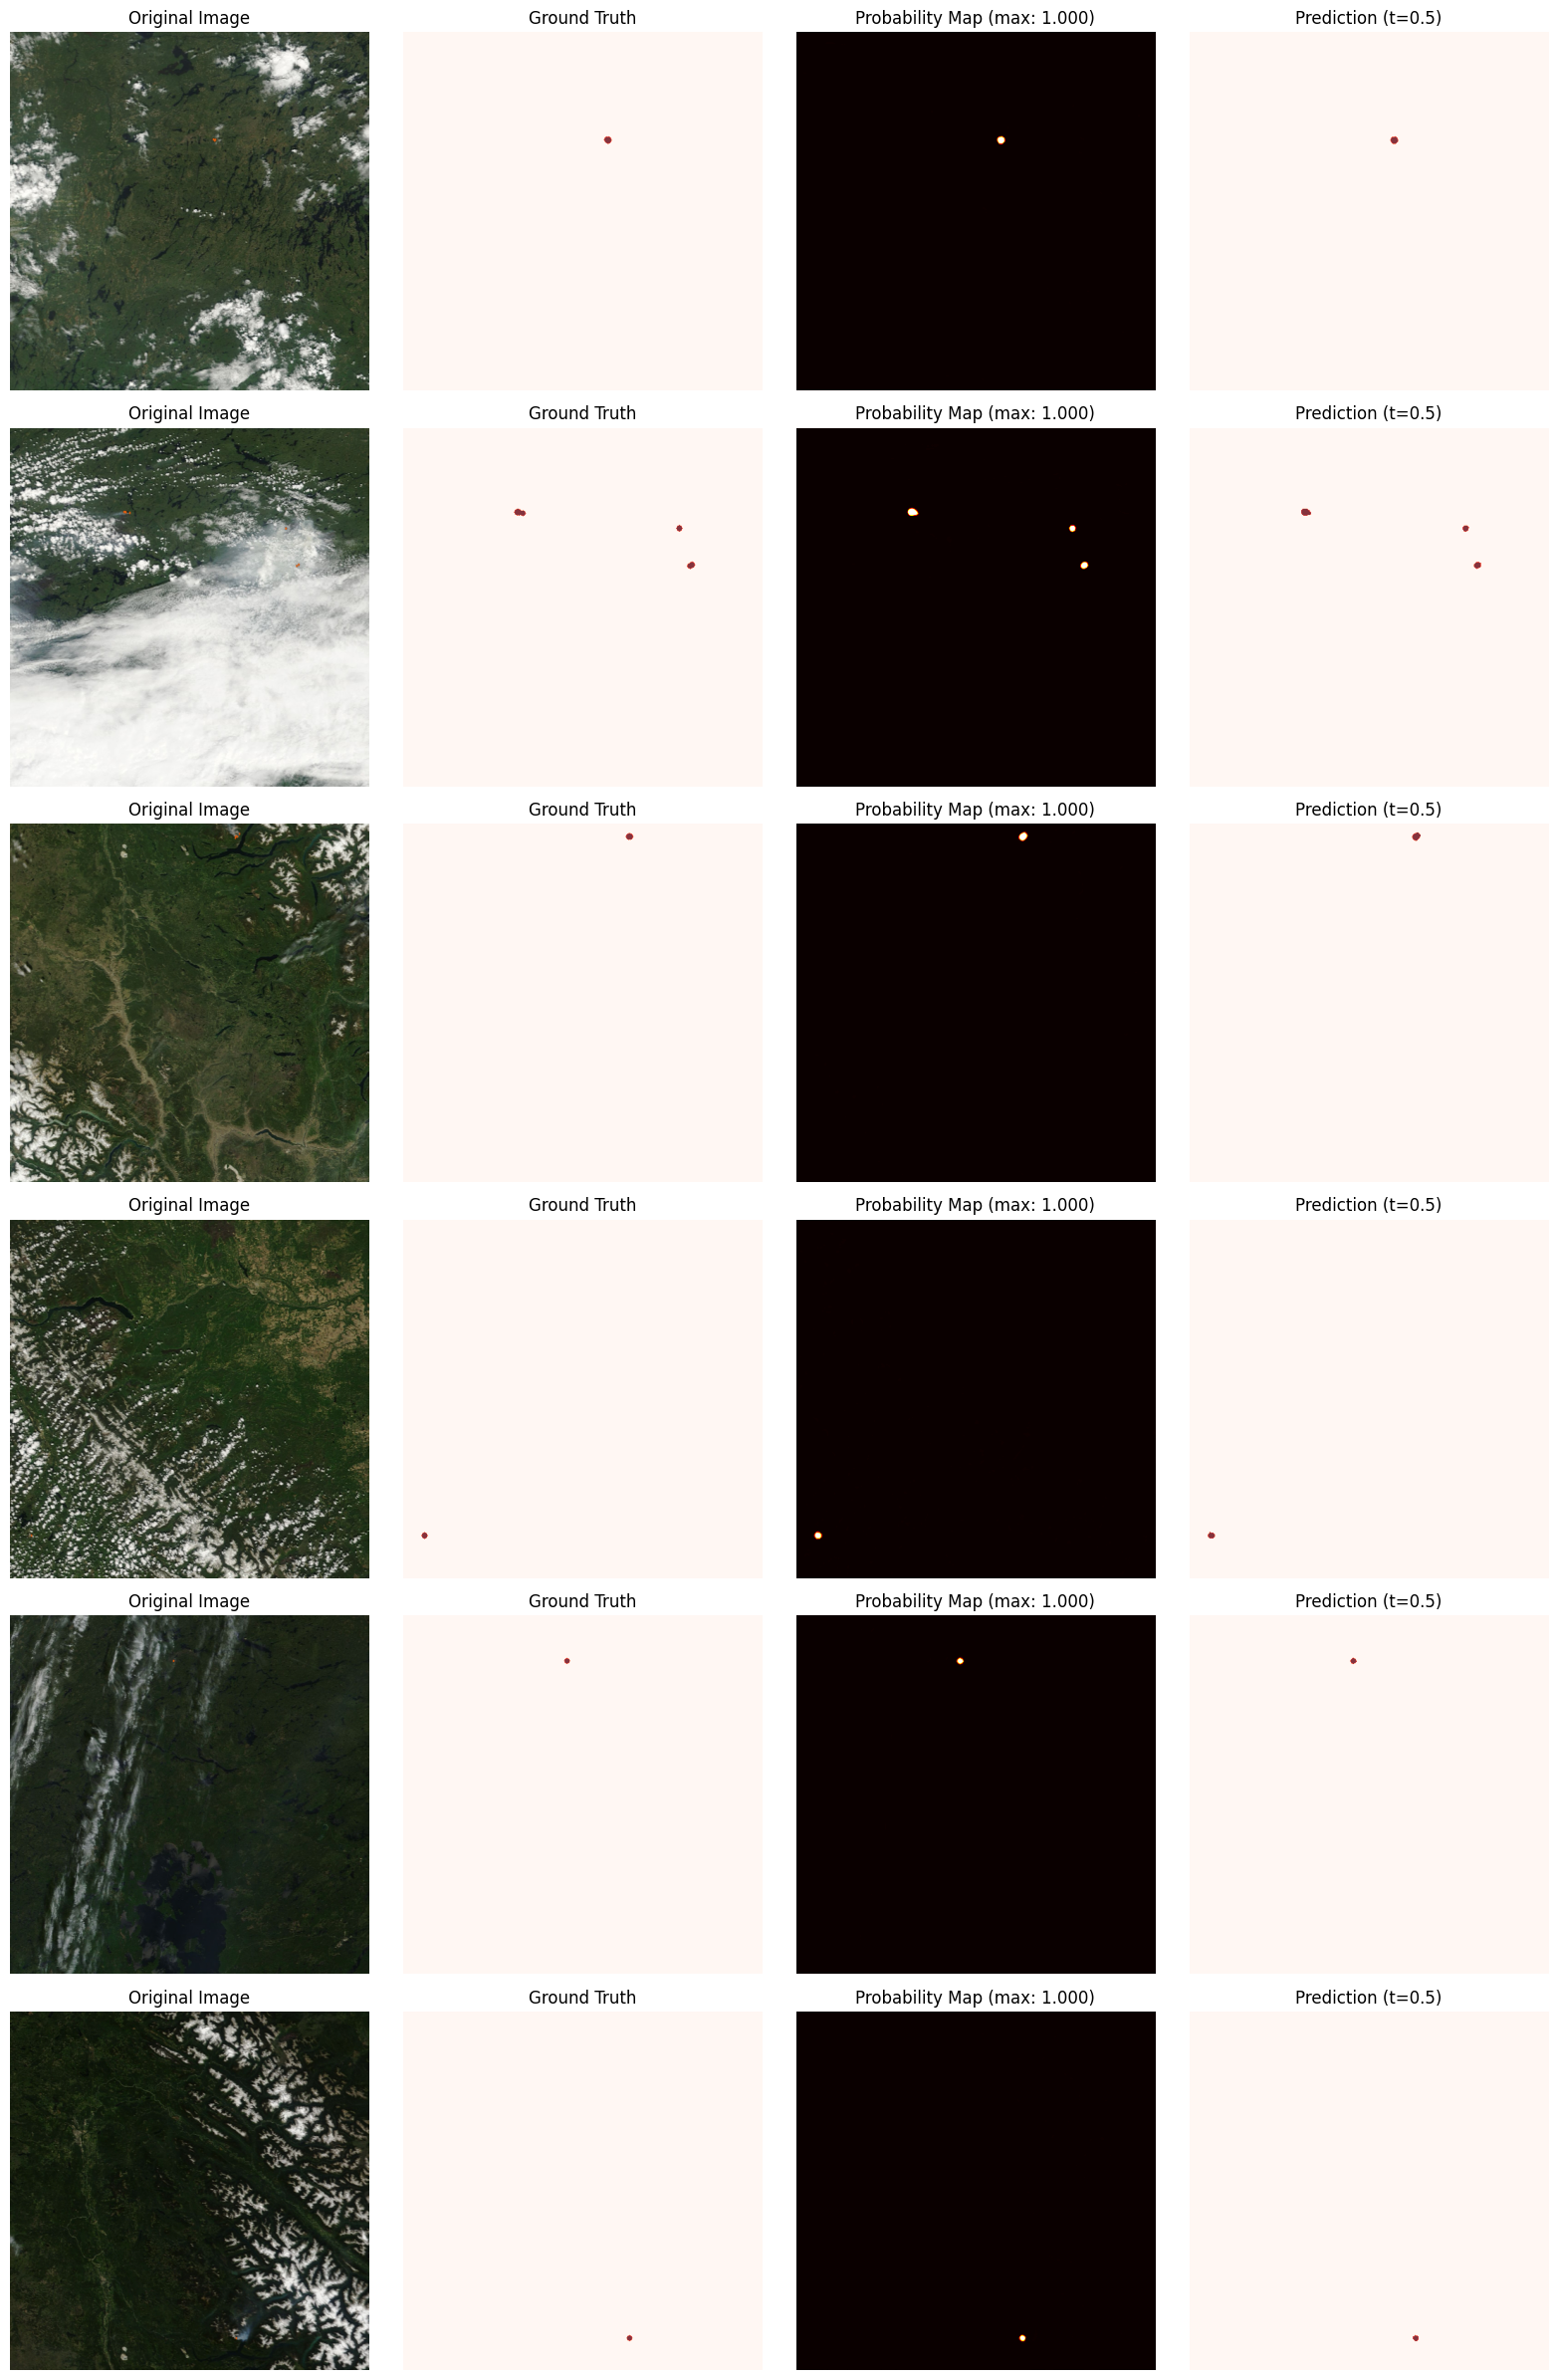

Validation Set Predictions:


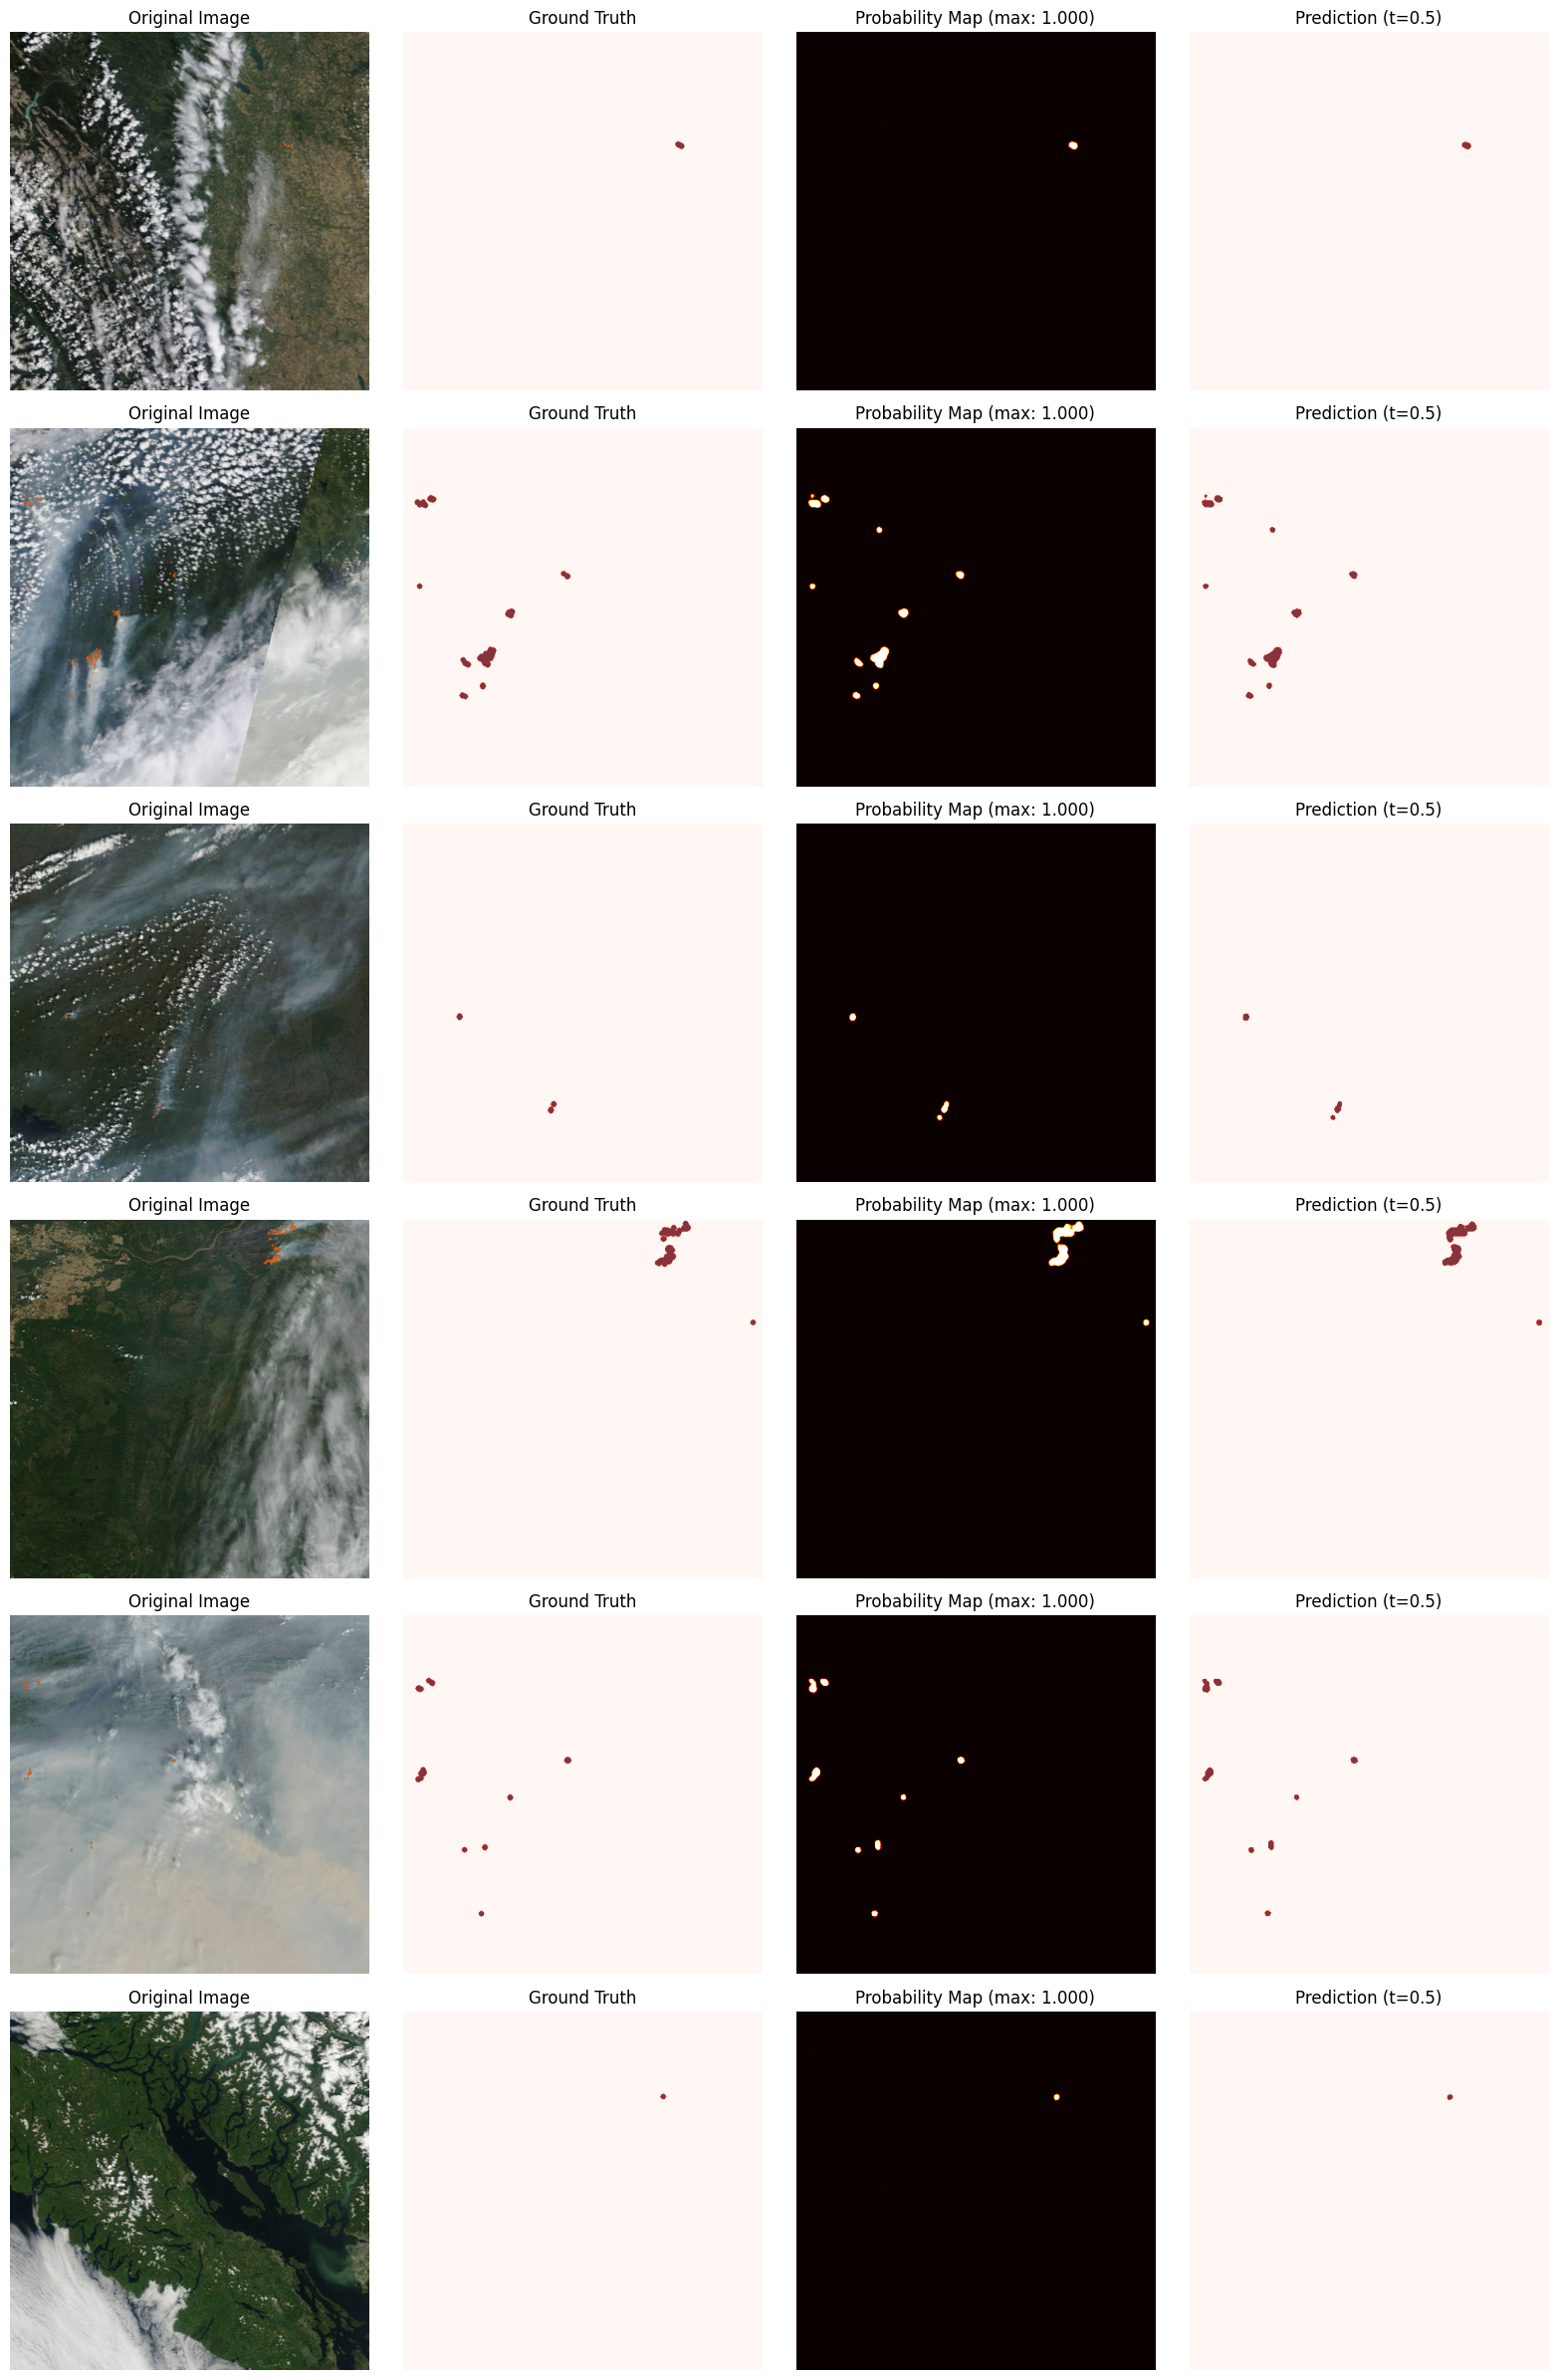


3. Threshold Analysis
Analyzing thresholds...
  Threshold 0.1: F1=0.846
  Threshold 0.2: F1=0.859
  Threshold 0.3: F1=0.865
  Threshold 0.4: F1=0.867
  Threshold 0.5: F1=0.867
  Threshold 0.6: F1=0.865
  Threshold 0.7: F1=0.861
  Threshold 0.8: F1=0.854


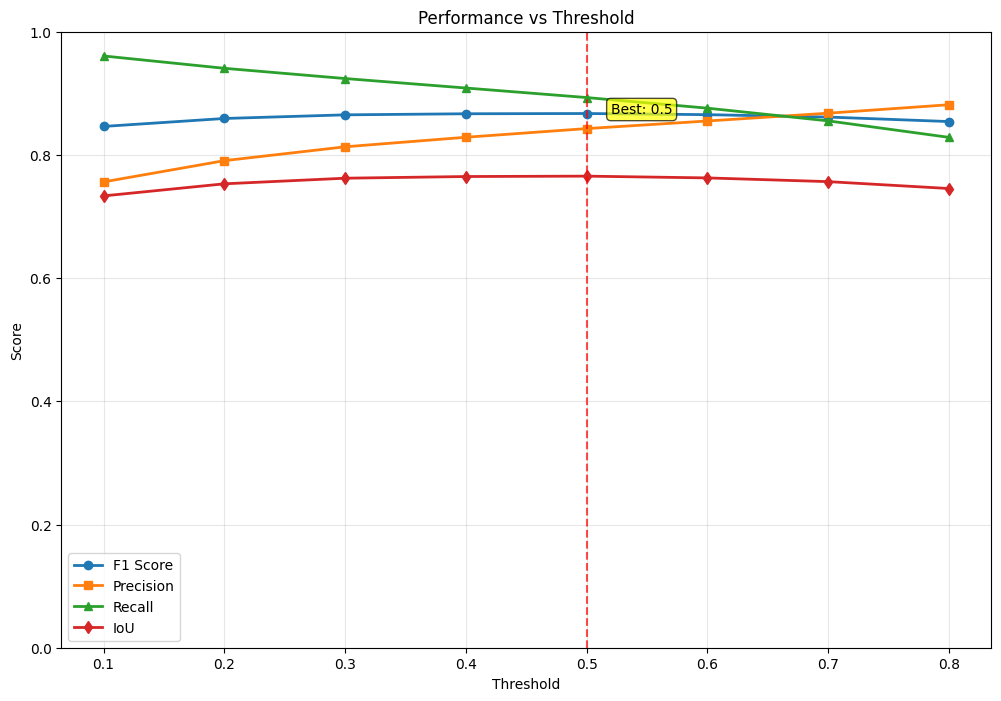


Optimal thresholds:
Best F1: 0.5
Best IoU: 0.5

4. Overlay Visualizations


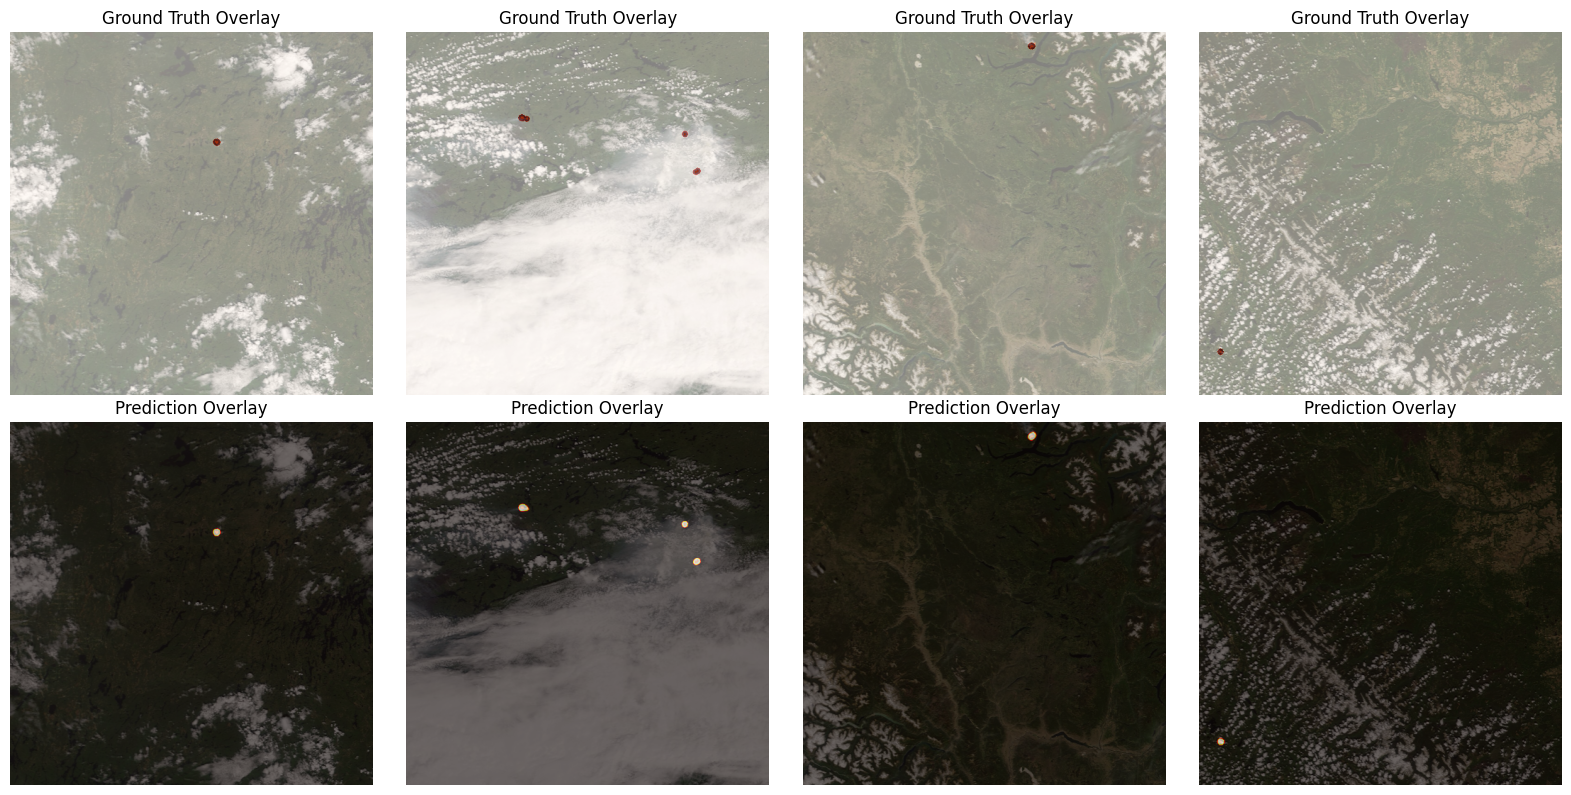

In [15]:
# ## 6. Run Visualizations

print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# Plot ROC and PR curves
print("\n1. ROC and Precision-Recall Curves")
plot_roc_pr_curves(test_probs, test_targets, "Test Set - ")
plot_roc_pr_curves(val_probs, val_targets, "Validation Set - ")

# Visualize predictions
print("\n2. Prediction Visualizations")
print("Test Set Predictions:")
visualize_predictions(model, test_loader, num_samples=6)

print("Validation Set Predictions:")
visualize_predictions(model, val_loader, num_samples=6)

# Threshold analysis
print("\n3. Threshold Analysis")
threshold_df = plot_threshold_analysis(model, test_loader)
print("\nOptimal thresholds:")
print(f"Best F1: {threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']:.1f}")
print(f"Best IoU: {threshold_df.loc[threshold_df['iou'].idxmax(), 'threshold']:.1f}")

# Overlay visualizations
print("\n4. Overlay Visualizations")
create_overlay_visualization(model, test_loader, num_samples=4)

In [16]:
# ## 7. Performance Summary

print("\n" + "="*50)
print("FINAL PERFORMANCE SUMMARY")
print("="*50)

# Create summary DataFrame
summary_data = {
    'Dataset': ['Test', 'Validation'],
    'Fire F1': [test_metrics.get('fire_f1', 0), val_metrics.get('fire_f1', 0)],
    'Mean IoU': [test_metrics.get('mean_iou', 0), val_metrics.get('mean_iou', 0)],
    'Precision': [test_metrics.get('fire_precision', 0), val_metrics.get('fire_precision', 0)],
    'Recall': [test_metrics.get('fire_detection_rate', 0), val_metrics.get('fire_detection_rate', 0)],
    'ROC AUC': [test_metrics.get('roc_auc', 0), val_metrics.get('roc_auc', 0)]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4))

# Class distribution analysis
print(f"\nClass Distribution Analysis:")
test_fire_ratio = np.mean(test_targets)
val_fire_ratio = np.mean(val_targets)
print(f"Test set fire pixel ratio: {test_fire_ratio:.4f} ({test_fire_ratio*100:.2f}%)")
print(f"Validation set fire pixel ratio: {val_fire_ratio:.4f} ({val_fire_ratio*100:.2f}%)")

print(f"\nModel is ready for Phase 2 (ConvLSTM) development!")
print(f"Current model achieves {test_metrics.get('fire_f1', 0):.1%} F1 score on test data.")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)


FINAL PERFORMANCE SUMMARY
      Dataset  Fire F1  Mean IoU  Precision  Recall  ROC AUC
0        Test   0.8672    0.7656     0.8428  0.8931   0.9998
1  Validation   0.8744    0.7769     0.8508  0.8994   0.9999

Class Distribution Analysis:
Test set fire pixel ratio: 0.0022 (0.22%)
Validation set fire pixel ratio: 0.0025 (0.25%)

Model is ready for Phase 2 (ConvLSTM) development!
Current model achieves 86.7% F1 score on test data.

ANALYSIS COMPLETE
